In [94]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [96]:
merged_dataset = pd.merge(transactions, customers, on='CustomerID', how='left')
merged_dataset = pd.merge(merged_dataset, products, on='ProductID', how='left')


##Feature Engineering

In [97]:
customer_profile = merged_dataset.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    purchase_frequency=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    category_preference=('Category', lambda x: x.value_counts().idxmax() if len(x) > 0 else None)
).reset_index()

In [98]:
print(customer_profile.columns)


Index(['CustomerID', 'total_spend', 'purchase_frequency',
       'avg_transaction_value', 'category_preference'],
      dtype='object')


In [99]:
# customer_profile = pd.merge(customer_profile, customers[['CustomerID', 'Region']], on='CustomerID', how='left')
# customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)


In [100]:
X = customer_profile[['total_spend', 'purchase_frequency', 'avg_transaction_value'] +
                     [col for col in customer_profile.columns if 'CategoryPreference' in col]]


In [101]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [123]:
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(X_scaled)
# Calculate DB Index and Silhouette Score
db_index = davies_bouldin_score(X_scaled, customer_profile['Cluster'])
sil_score = silhouette_score(X_scaled, customer_profile['Cluster'])

#

In [124]:
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

DB Index: 0.8170773723152535
Silhouette Score: 0.3612867580911339


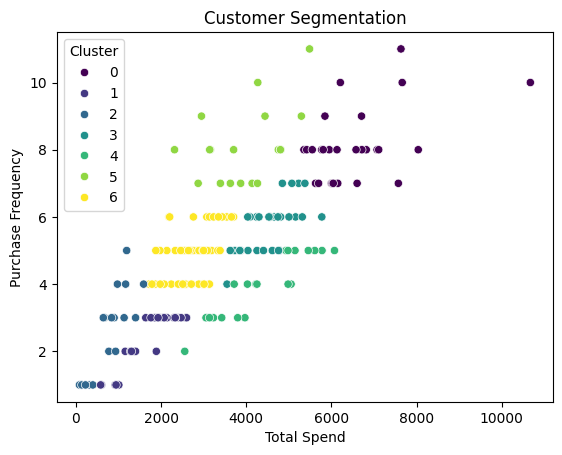

In [125]:
sns.scatterplot(x=customer_profile['total_spend'], y=customer_profile['purchase_frequency'], hue=customer_profile['Cluster'], palette="viridis")
plt.title("Customer Segmentation")
plt.xlabel("Total Spend")
plt.ylabel("Purchase Frequency")
plt.show()

In [126]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
customer_profile['PCA1'] = principal_components[:, 0]
customer_profile['PCA2'] = principal_components[:, 1]

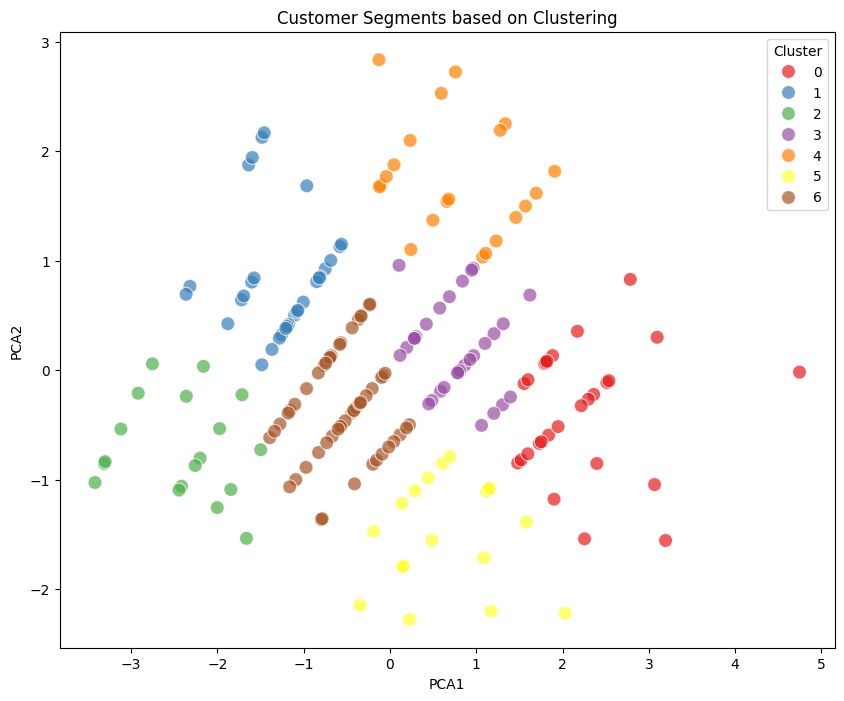

In [127]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set1', data=customer_profile, s=100, alpha=0.7)
plt.title('Customer Segments based on Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [128]:
customer_profile[['CustomerID', 'Cluster']].to_csv('Customer_Segments.csv', index=False)